In [2]:
import tensorflow as tf
import math
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
assert tf.config.list_physical_devices('GPU'), "No GPU detected: Check your Kaggle environment settings."


Num GPUs Available: 1


In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DROPOUT_RATE = 0.3
INITIAL_LR = 0.001
EPOCHS = 100
SEED = 42

train_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/train'
val_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/val'
test_dir = '/kaggle/input/cwd30-corn-grass-weeds-new-aug-split-33/data_final_split/test'

EXPERIMENT_NAME = "densenet_shuffle"  # Options: "densenet_eca", "densenet_ca", "densenet_both"
ATTENTION_TYPE = "shuffle"  # Options: cbam, simam, gam, triplet, shuffle, bam


In [5]:
datagen_args = dict(rescale=1./255)
train_gen = ImageDataGenerator(**datagen_args)
val_gen = ImageDataGenerator(**datagen_args)
test_gen = ImageDataGenerator(**datagen_args)
train_flow = train_gen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True, seed=SEED)
val_flow = val_gen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_flow = test_gen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
num_classes = train_flow.num_classes


Found 14219 images belonging to 43 classes.
Found 11955 images belonging to 43 classes.
Found 11958 images belonging to 43 classes.


In [6]:
# ============================================================================
# Shuffle Attention (SA-Net) - 2021
# Efficient: Parallel channel and spatial with shuffle
# Paper: "SA-Net: Shuffle Attention for Deep Convolutional Neural Networks"
# ============================================================================
class ShuffleAttention(layers.Layer):
    """
    Shuffle Attention: Parallel channel and spatial attention with group shuffle
    More efficient than CBAM

    Args:
        groups: number of groups for channel shuffle (default: 64)
    """
    def __init__(self, groups=64, **kwargs):
        super(ShuffleAttention, self).__init__(**kwargs)
        self.groups = groups

    def build(self, input_shape):
        channels = input_shape[-1]
        self.g = channels // 2

        # Channel attention
        self.gap = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(self.g // 16, activation='relu')
        self.fc2 = layers.Dense(self.g)

        # Spatial attention
        self.conv_spatial = layers.Conv2D(1, kernel_size=7, padding='same')

        super(ShuffleAttention, self).build(input_shape)

    def channel_shuffle(self, x, groups):
        """Channel shuffle operation"""
        b, h, w, c = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        x = tf.reshape(x, [b, h, w, groups, c // groups])
        x = tf.transpose(x, [0, 1, 2, 4, 3])
        x = tf.reshape(x, [b, h, w, c])
        return x

    def call(self, inputs):
        b, h, w, c = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3]

        # Split into two groups
        x1, x2 = tf.split(inputs, 2, axis=-1)

        # Channel attention on x1
        gap = self.gap(x1)
        channel_att = self.fc2(self.fc1(gap))
        channel_att = tf.nn.sigmoid(tf.reshape(channel_att, [b, 1, 1, self.g]))
        x1_out = x1 * channel_att

        # Spatial attention on x2
        spatial_att = tf.reduce_mean(x2, axis=-1, keepdims=True)
        spatial_att = self.conv_spatial(spatial_att)
        spatial_att = tf.nn.sigmoid(spatial_att)
        x2_out = x2 * spatial_att

        # Concatenate and shuffle
        output = tf.concat([x1_out, x2_out], axis=-1)
        output = self.channel_shuffle(output, 2)

        return output

    def get_config(self):
        config = super(ShuffleAttention, self).get_config()
        config.update({"groups": self.groups})
        return config




def build_densenet_with_attention(
    num_classes,
    img_size=(224, 224),
    attention_name='cbam',
    dropout_rate=0.3
):
    """
    Build DenseNet121 with modern attention mechanisms

    Architecture: Input -> DenseNet121 -> ATTENTION -> Dense Layers

    Args:
        num_classes: number of output classes
        img_size: input image size
        attention_name: which attention to use
        dropout_rate: dropout rate for dense layers

    Returns:
        Keras Model
    """
    from tensorflow.keras.applications import DenseNet121
    from tensorflow.keras import Model

    # Load DenseNet121 backbone
    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=img_size + (3,)
    )

    x = base_model.output

    # Add Attention Module
    attention_map = {
        # 'cbam': CBAM,
        # 'simam': SimAM,
        # 'gam': GAM,
        # 'triplet': TripletAttention,
        'shuffle': ShuffleAttention,
        # 'bam': BAM
    }

    if attention_name.lower() in attention_map:
        AttentionLayer = attention_map[attention_name.lower()]
        x = AttentionLayer(name=f'{attention_name}_attention')(x)
        print(f"✓ Added {attention_name.upper()} attention after DenseNet121")
    else:
        print(f"⚠ Unknown attention: {attention_name}. Proceeding without attention.")

    # Classification Head (matching your original architecture)
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dropout(dropout_rate, name='dropout_1')(x)

    x = layers.Dense(1024, activation='relu', name='fc1')(x)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Dropout(dropout_rate, name='dropout_2')(x)

    x = layers.Dense(512, activation='relu', name='fc2')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Dropout(dropout_rate, name='dropout_3')(x)

    x = layers.Dense(256, activation='relu', name='fc3')(x)
    x = layers.BatchNormalization(name='bn3')(x)
    x = layers.Dropout(dropout_rate, name='dropout_4')(x)

    x = layers.Dense(128, activation='relu', name='fc4')(x)

    output = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(
        inputs=base_model.input,
        outputs=output,
        name=f'DenseNet121_{attention_name}'
    )

    return model




In [7]:
print(f"\n{'='*70}")
print(f"Building DenseNet121 with {ATTENTION_TYPE.upper()} attention")
print(f"{'='*70}\n")

model = build_densenet_with_attention(
    num_classes=num_classes,
    img_size=IMG_SIZE,
    attention_name=ATTENTION_TYPE,
    dropout_rate=DROPOUT_RATE
)

# Make entire model trainable (same as your setup)
model.trainable = True

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=INITIAL_LR,
    weight_decay=0.01
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



Building DenseNet121 with SHUFFLE attention



I0000 00:00:1762681454.252648      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✓ Added SHUFFLE attention after DenseNet121


In [8]:
print("\nModel Summary:")
print(f"Total parameters: {model.count_params():,}")
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")
print(f"Parameter increase vs baseline: +{model.count_params() - 8788843:,}")



Model Summary:
Total parameters: 8,822,205
Trainable parameters: 8,734,973
Parameter increase vs baseline: +33,362


In [9]:
checkpoint_cb = ModelCheckpoint(
    "best_densenet_model.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [checkpoint_cb, earlystop_cb, reduce_lr]

print(f"\n{'='*70}")
print("Starting training...")
print(f"{'='*70}\n")

history = model.fit(
    train_flow,
    epochs=EPOCHS,
    validation_data=val_flow,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

# Save history
with open(f'{EXPERIMENT_NAME}_history.json', 'w') as f:
    json.dump(history.history, f)



Starting training...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1762681559.096953     124 service.cc:148] XLA service 0x7cac50001ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762681559.097981     124 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762681568.617406     124 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762681656.963251     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.1552 - loss: 3.1233
Epoch 1: val_accuracy improved from -inf to 0.28365, saving model to best_densenet_model.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 480s 637ms/step - accuracy: 0.1555 - loss: 3.1218 - val_accuracy: 0.2836 - val_loss: 2.5495 - learning_rate: 0.0010
Epoch 2/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.4757 - loss: 1.4899
Epoch 2: val_accuracy improved from 0.28365 to 0.45420, saving model to best_densenet_model.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 114s 256ms/step - accuracy: 0.4758 - loss: 1.4896 - val_accuracy: 0.4542 - val_loss: 1.7353 - learning_rate: 0.0010
Epoch 3/100
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6241 - loss: 1.0302
Epoch 3: val_accuracy improved from 0.45420 to 0.61556, saving model to best_densenet_model.h5
445/445 ━━━━━━━━━━━━━━━━━━━━ 118s 266ms/step - accuracy: 0.6242 - loss: 1.0301 - val_accuracy: 0.6156 - val_loss: 1.1291 - learning_rate: 0.0010
Epoch 4/100
445/445 ━━━━━━━━

In [10]:
print("\nEvaluating on test set...")

test_flow.reset()
y_true = test_flow.classes
y_pred_probs = model.predict(test_flow, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

target_names = list(test_flow.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=target_names, digits=4, output_dict=True)
cm = confusion_matrix(y_true, y_pred)
test_loss, test_acc = model.evaluate(test_flow, verbose=0)

# Metrics
precision = report["macro avg"]["precision"]
recall = report["macro avg"]["recall"]
f1 = report["macro avg"]["f1-score"]
num_params = model.count_params()


print(f"\n{'='*70}")
print("FINAL RESULTS")
print(f"{'='*70}")
print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Attention Type: {ATTENTION_TYPE.upper()}")
print(f"{'-'*70}")
print(f"Test Loss:      {test_loss:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1 Score:       {f1:.4f}")
print(f"Parameters:     {num_params:,}")
print(f"Param increase: +{num_params - 8788843:,}")
print(f"{'='*70}\n")

# Compare with baseline
baseline_acc = 0.9489
baseline_f1 = 0.9235
print("COMPARISON WITH BASELINE:")
print(f"Accuracy improvement: {(test_acc - baseline_acc)*100:+.2f}%")
print(f"F1 improvement:       {(f1 - baseline_f1)*100:+.2f}%")



Evaluating on test set...
374/374 ━━━━━━━━━━━━━━━━━━━━ 145s 352ms/step

FINAL RESULTS
Experiment: densenet_shuffle
Attention Type: SHUFFLE
----------------------------------------------------------------------
Test Loss:      0.1859
Test Accuracy:  0.9550
Precision:      0.9205
Recall:         0.9418
F1 Score:       0.9296
Parameters:     8,822,205
Param increase: +33,362

COMPARISON WITH BASELINE:
Accuracy improvement: +0.61%
F1 improvement:       +0.61%


In [11]:
results = {
    "Model": [EXPERIMENT_NAME],
    "Attention": [ATTENTION_TYPE],
    "Params": [num_params],
    "Param_increase": [num_params - 8788843],
    "Test_Loss": [f"{test_loss:.4f}"],
    "Test_Acc": [f"{test_acc:.4f}"],
    "Precision": [f"{precision:.4f}"],
    "Recall": [f"{recall:.4f}"],
    "F1": [f"{f1:.4f}"],
    "Acc_vs_baseline": [f"{(test_acc - baseline_acc)*100:+.2f}%"],
    "F1_vs_baseline": [f"{(f1 - baseline_f1)*100:+.2f}%"]
}

import pandas as pd
df = pd.DataFrame(results)
print("\n" + df.to_markdown(index=False))

# Save to CSV for easy comparison
df.to_csv(f'{EXPERIMENT_NAME}_results.csv', index=False)

# Save model
model.save(f'{EXPERIMENT_NAME}_final_model.keras')
model.save_weights(f'{EXPERIMENT_NAME}_final.weights.h5')



| Model            | Attention   |   Params |   Param_increase |   Test_Loss |   Test_Acc |   Precision |   Recall |     F1 | Acc_vs_baseline   | F1_vs_baseline   |
|:-----------------|:------------|---------:|-----------------:|------------:|-----------:|------------:|---------:|-------:|:------------------|:-----------------|
| densenet_shuffle | shuffle     |  8822205 |            33362 |      0.1859 |      0.955 |      0.9205 |   0.9418 | 0.9296 | +0.61%            | +0.61%           |


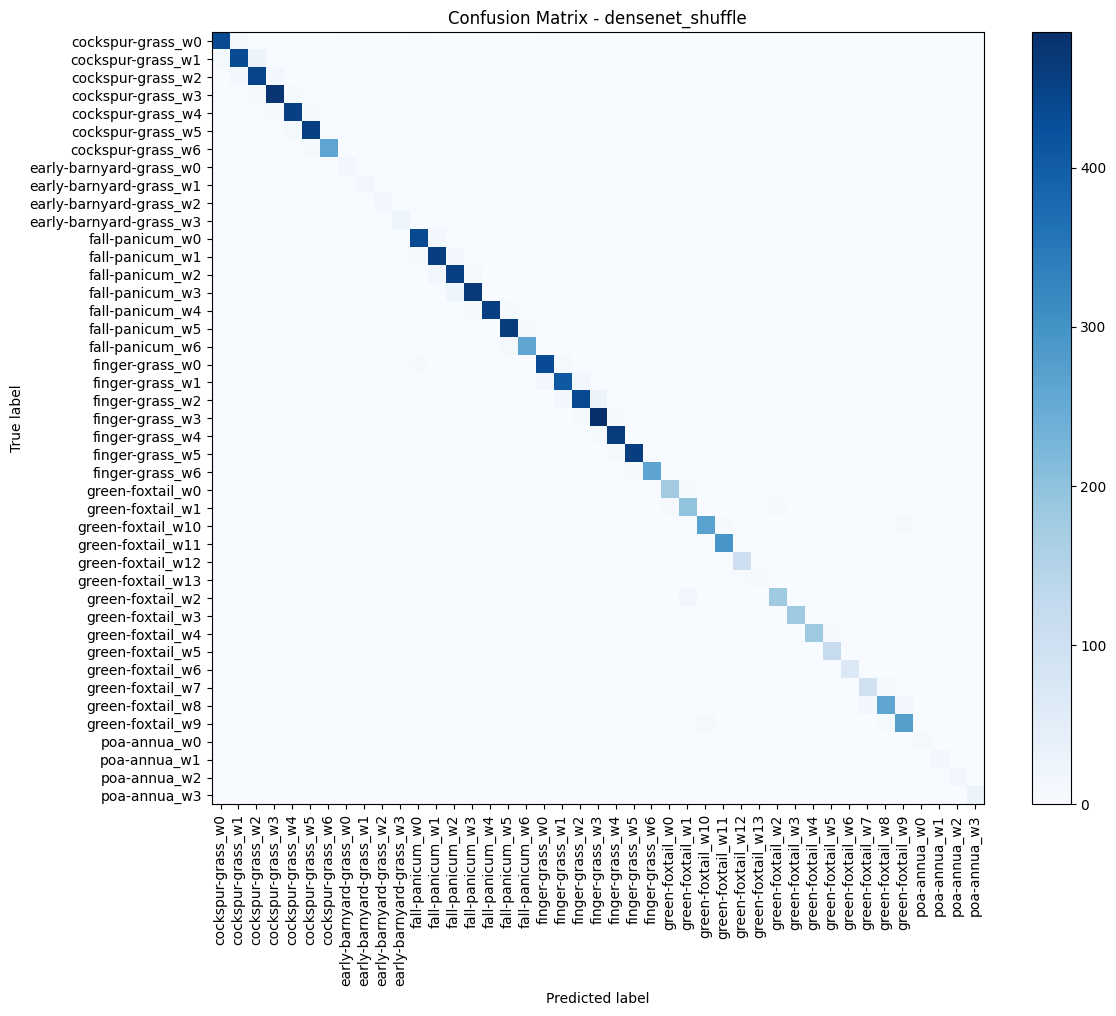

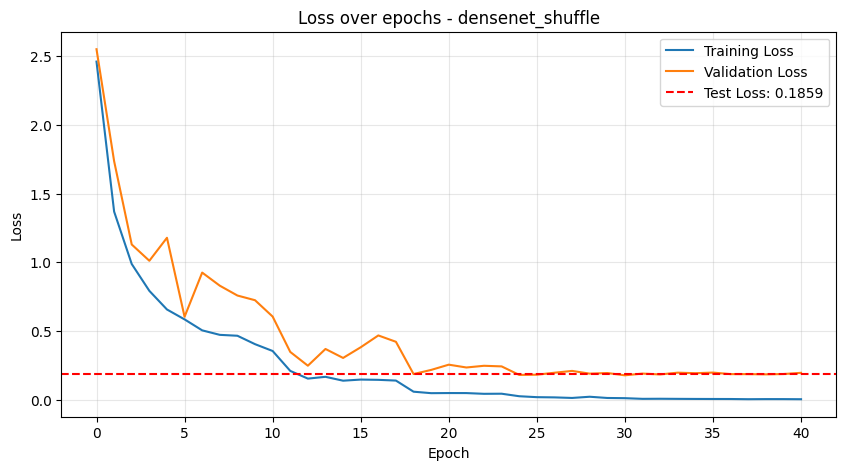

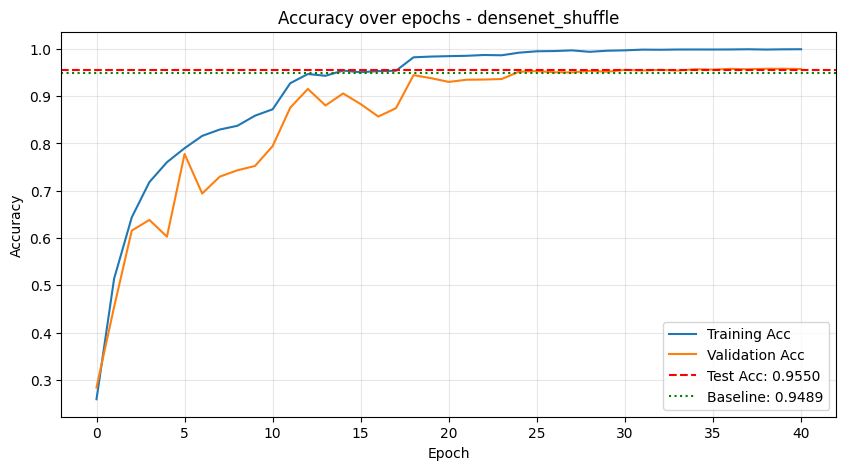


All results saved with prefix: densenet_shuffle_
Training complete! 🎉


In [12]:
# Confusion Matrix
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - {EXPERIMENT_NAME}")
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=90)
plt.yticks(tick_marks, target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(f'{EXPERIMENT_NAME}_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Loss curves
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.legend()
plt.title(f"Loss over epochs - {EXPERIMENT_NAME}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.savefig(f'{EXPERIMENT_NAME}_loss.png', dpi=150, bbox_inches='tight')
plt.show()

# Accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Training Acc")
plt.plot(history.history["val_accuracy"], label="Validation Acc")
plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Acc: {test_acc:.4f}')
plt.axhline(y=baseline_acc, color='g', linestyle=':', label=f'Baseline: {baseline_acc:.4f}')
plt.legend()
plt.title(f"Accuracy over epochs - {EXPERIMENT_NAME}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.savefig(f'{EXPERIMENT_NAME}_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nAll results saved with prefix: {EXPERIMENT_NAME}_")
print("Training complete! 🎉")


In [13]:
!zip -r shuffle.zip /kaggle/working/

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/densenet_shuffle_final.weights.h5 (deflated 12%)
  adding: kaggle/working/densenet_shuffle_accuracy.png (deflated 10%)
  adding: kaggle/working/densenet_shuffle_history.json (deflated 61%)
  adding: kaggle/working/densenet_shuffle_confusion_matrix.png (deflated 24%)
  adding: kaggle/working/densenet_shuffle_loss.png (deflated 10%)
  adding: kaggle/working/best_densenet_model.h5 (deflated 12%)
  adding: kaggle/working/densenet_shuffle_final_model.keras (deflated 12%)
  adding: kaggle/working/densenet_shuffle_results.csv (deflated 29%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
